# LegacyHalos SersicFitting

This notebook demonstrates how we fit the 1D surface brightness profiles using various parametric (e.g., Sersic) models, using one galaxy as a toy example.

### Imports, paths, and other preliminaries.

In [1]:
import os, pdb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.4, palette='Set2')
%matplotlib inline

In [3]:
pixscale = 0.262
band = ('g', 'r', 'z')
refband = 'r'

### Define a wavelength-dependent Sersic model

In [4]:
from astropy.modeling import Fittable2DModel

In [5]:
class SersicWaveModel(Fittable2DModel):
    """
    Define a surface brightness profile model which is the sum of three Sersic
    models connected by a Sersic index and half-light radius which varies
    as a power-law function of wavelength.
    
    See http://docs.astropy.org/en/stable/modeling/new.html#a-step-by-step-definition-of-a-1-d-gaussian-model
    for useful info.
    
    ToDo: convolve the model with the PSF.

    """
    from astropy.modeling import Parameter
    
    nref = Parameter(default=4, bounds=(0.1, 8))
    r50ref = Parameter(default=10, bounds=(1e-3, 30)) # [arcsec]
    alpha = Parameter(default=0.0, bounds=(-1, 1))
    beta = Parameter(default=0.0, bounds=(-1, 1))
    mu50_g = Parameter(default=1.0)#, bounds=(1e-3, 1e3)) # [nanomaggies at r50] [mag=15-30]
    mu50_r = Parameter(default=1.0)#, bounds=(1e-3, 1e3))
    mu50_z = Parameter(default=1.0)#, bounds=(1e-3, 1e3))

    linear = False
    
    def __init__(self, nref=nref.default, r50ref=r50ref.default, 
                 alpha=alpha.default, beta=beta.default, 
                 mu50_g=mu50_g.default, mu50_r=mu50_r.default, mu50_z=mu50_z.default, 
                 psfsigma_g=0.0, psfsigma_r=0.0, psfsigma_z=0.0, 
                 lambda_ref=6470, lambda_g=4890, lambda_r=6470, lambda_z=9196, 
                 **kwargs):

        self.band = ('g', 'r', 'z')
        
        #from speclite import filters
        #filt = filters.load_filters('decam2014-g', 'decam2014-r', 'decam2014-z')
        #print(filt.effective_wavelengths.value)
        
        self.lambda_g = lambda_g
        self.lambda_r = lambda_r
        self.lambda_z = lambda_z
        self.lambda_ref = lambda_ref
        
        self.psfsigma_g = psfsigma_g
        self.psfsigma_r = psfsigma_r
        self.psfsigma_z = psfsigma_z
        
        super(SersicWaveModel, self).__init__(nref=nref, r50ref=r50ref, alpha=alpha, 
                                              beta=beta, mu50_g=mu50_g, mu50_r=mu50_r, 
                                              mu50_z=mu50_z, **kwargs)
        
    def get_sersicn(self, nref, lam, alpha):
        return nref * (lam / self.lambda_ref)**alpha
    
    def get_r50(self, r50ref, lam, beta):
        return r50ref * (lam / self.lambda_ref)**beta
    
    def evaluate(self, r, w, nref, r50ref, alpha, beta, mu50_g, mu50_r, mu50_z):
        """Evaluate the wavelength-dependent Sersic model.
        
        Args:
          r : radius [kpc]
          w : wavelength [Angstrom]
          nref : Sersic index at the reference wavelength lambda_ref
          r50ref : half-light radius at lambda_ref
          alpha : power-law slope for the Sersic index
          beta : power-law slope for the half-light radius
          mu50_g : g-band surface brignthess at r=r50_g
          mu50_r : r-band surface brignthess at r=r50_r
          mu50_z : z-band surface brignthess at r=r50_z
        
        """
        from scipy.special import gammaincinv
        from astropy.convolution import Gaussian1DKernel, convolve
        
        mu = np.zeros_like(r)
        
        # Build the surface brightness profile at each wavelength.
        for lam, psfsig, mu50 in zip( (self.lambda_g, self.lambda_r, self.lambda_z), 
                                      (self.psfsigma_g, self.psfsigma_r, self.psfsigma_z), 
                                      (mu50_g, mu50_r, mu50_z) ):
            
            n = self.get_sersicn(nref, lam, alpha)
            r50 = self.get_r50(r50ref, lam, beta)
            
            indx = w == lam
            if np.sum(indx) > 0:
                mu_int = mu50 * np.exp(-gammaincinv(2 * n, 0.5) * ((r[indx] / r50) ** (1 / n) - 1))
            
                # smooth with the PSF
                if psfsig > 0:
                    g = Gaussian1DKernel(stddev=psfsig)#, mode='linear_interp')
                    mu_smooth = convolve(mu_int, g, normalize_kernel=True, boundary='extend')
                    fix = (r[indx] > 5 * psfsig)
                    mu_smooth[fix] = mu_int[fix] # replace with original values
                    mu[indx] = mu_smooth
                else:
                    mu[indx] = mu_int
        
        return mu
    
    def plot(self, radius, wave, sbwave, model=None):
        """Plot a wavelength-dependent surface brightness profile.
        
        model - instantiation of SersicWaveModel()
        """
        colors = iter(sns.color_palette())
        markers = iter(['o', 's', 'D'])
    
        fig, ax = plt.subplots(figsize=(8, 5))
        for band, lam in zip( self.band, (self.lambda_g, self.lambda_r, self.lambda_z) ):
            good = lam == wave
            rad = radius[good]
            sb = sbwave[good]

            srt = np.argsort(rad)
            rad, sb = rad[srt], sb[srt]

            if model:
                n = model.get_sersicn(nref=model.nref, lam=lam, alpha=model.alpha)
                r50 = model.get_r50(r50ref=model.nref, lam=lam, beta=model.beta)
                label = r'${}:\ n={:.2f}\ r_{{50}}={:.2f}$ arcsec'.format(band, n, r50)
            else:
                label = band
            
            col = next(colors)
            #ax.plot(rad, 22.5-2.5*np.log10(sb), label=band)
            ax.scatter(rad, 22.5-2.5*np.log10(sb), color=col,
                       alpha=1, s=50, label=label, marker=next(markers))
        
            # optionally overplot the model
            if model is not None:
                sb_model = model(rad, wave[good][srt])
                ax.plot(rad, 22.5-2.5*np.log10(sb_model), color='k', #color=col, 
                            ls='--', lw=2, alpha=0.5)
            
        ax.set_xlabel('Galactocentric radius (arcsec)')
        ax.set_ylabel(r'Surface Brightness $\mu$ (mag arcsec$^{-2}$)')
        ax.invert_yaxis()
        #ax.set_yscale('log')
        ax.legend(loc='upper right', markerscale=1.2)    

#### Simulate a data set and plot it

Create a "galaxy" with a g-, r-, and z-band surface brightness profile measured over different radii.  Choose the Sersic index to vary with wavelength as $\beta=0.1$ with $n_{ref}=2.8$, and the half-light radius to vary as $\alpha=-0.2$ with $r_{ref}=8$ kpc.

In [6]:
def simulate_sbprofiles(errfactor=0.2, seed=None, verbose=True, plot=False):
    """Simple script to simulate grz surface brightness profiles."""

    # instantiate a nominal model
    model = SersicWaveModel(beta=0.1, alpha=-0.2, r50ref=8, nref=2.8, 
                            mu50_g=0.5, mu50_r=1.0, mu50_z=1.5,
                            psfsigma_g=1, psfsigma_r=1, psfsigma_z=1)
    if verbose:
        print(model)

    rand = np.random.RandomState(seed)

    minradius = 0.02
    maxradius = 15.0
    nrad = (45, 38, 41) # number of measurements per bandpass g, r, z

    # build the wavelength and radius vector
    radius = []
    wave = []
    for lam, nn in zip( (model.lambda_g, model.lambda_r, model.lambda_z), nrad ):
        # uniform sampling makes the PSF convolution smoother
        #rad = rand.uniform(minradius, maxradius, nn)
        rad = np.linspace(minradius, maxradius, nn) 

        radius.append(rad)
        wave.append(np.repeat(lam, nn))
        
    radius = np.hstack(radius)
    wave = np.hstack(wave)

    # evaluate the model and add variance
    sb = model(radius, wave)
    sb += rand.normal(loc=0, scale=sb*errfactor)
    
    if plot:
        model.plot(radius, wave, sb, model=model)
        
    return radius, wave, sb

Model: SersicWaveModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    nref r50ref alpha beta mu50_g mu50_r mu50_z
    ---- ------ ----- ---- ------ ------ ------
     2.8    8.0  -0.2  0.1    0.5    1.0    1.5


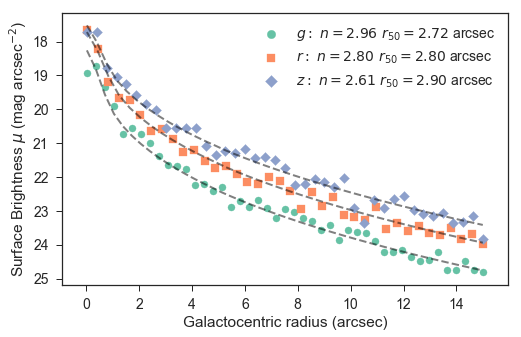

In [7]:
radius, wave, sb = simulate_sbprofiles(plot=True)

### Now test on real data

Read a surface brightness profile and fit it.

In [8]:
from legacyhalos import io
from legacyhalos.util import ellipse_sbprofile
from legacyhalos.qa import display_ellipse_sbprofile

In [9]:
sample = io.read_sample(first=0, last=0)

Read 1562 objects from /Users/ioannis/research/projects/legacyhalos/legacyhalos-parent-upenn.fits [LSPHOT]
Read 1562 objects from /Users/ioannis/research/projects/legacyhalos/legacyhalos-parent-upenn.fits [REDMAPPER]
Read 1562 objects from /Users/ioannis/research/projects/legacyhalos/legacyhalos-parent-upenn.fits [SDSSPHOT]
Renaming column objid-->sdss_objid in [SDSSPHOT] extension.
Sample contains 1 objects with first, last indices 0, 0


In [10]:
objid, objdir = io.get_objid(sample)
ellipsefit = io.read_ellipsefit(objid, objdir)
sbprofile = ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                              pixscale=pixscale)

In [11]:
sbprofile.keys()

dict_keys(['smaunit', 'sma', 'mu_g', 'mu_g_err', 'mu_r', 'mu_r_err', 'mu_z', 'mu_z_err', 'gr', 'rz', 'gr_err', 'rz_err'])

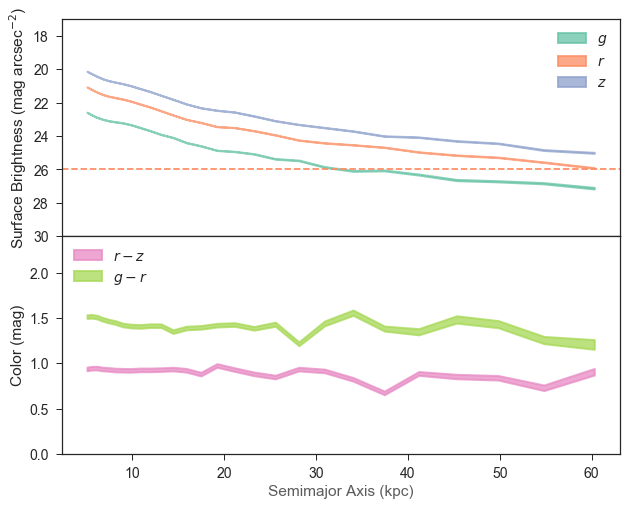

In [12]:
display_ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                          pixscale=pixscale, sersicfit=None)

In [13]:
class SersicWaveFit(object):
    """Fit surface brightness profiles with the SersicWaveModel model."""
    
    def __init__(self, sbprofile, fix_alpha=False, fix_beta=False, seed=None):
        """sbprofile is the output of legacyhalos.util.ellipse_sbprofile
        
        """
        from astropy.modeling import fitting

        self.rand = np.random.RandomState(seed)
        
        # initialize the fitter
        self.fitter = fitting.LevMarLSQFitter()
        
        # initialize the fit (need to "ball" this step and include the PSF width!)
        print('psf width needs to come from the sb profile!')
        self.fixed = {'alpha': fix_alpha, 'beta': fix_beta}
        self.initfit = SersicWaveModel(fixed=self.fixed,
                                       psfsigma_g=0.5, 
                                       psfsigma_r=0.5, 
                                       psfsigma_z=0.5)
        self.nparams = len(self.initfit.parameters)

        # parse the input sbprofile into the format that SersicWaveModel() expects
        sb, sberr, wave, radius = [], [], [], []
        for band, lam in zip( self.initfit.band, (self.initfit.lambda_g, 
                                                  self.initfit.lambda_r, 
                                                  self.initfit.lambda_z) ):
            # any quality cuts on stop_code here?!?
            wave.append(np.repeat(lam, len(sbprofile['sma'])))
            rad = sbprofile['sma'] # must be in arcsec!
            
            flux, ferr = self._mu2flux(mu=sbprofile['mu_{}'.format(band)],
                                       muerr=sbprofile['mu_{}_err'.format(band)])
            
            radius.append(rad)
            sb.append(flux)
            sberr.append(ferr)

        self.sb = np.hstack(sb)
        self.sberr = np.hstack(sberr)
        self.wave = np.hstack(wave)
        self.radius = np.hstack(radius)

    def _mu2flux(self, mu, muerr=None):
        """Convert surface brightness mu to linear flux in nanomaggies."""
        flux = 10**( -0.4 * (mu - 22.5) )
        if muerr is not None:
            ferr = 0.4 * np.log(10) * flux * muerr
            return flux, ferr
        else:
            return flux
    
    def chi2(self, bestfit):
        dof = len(self.sb) - len(bestfit.parameters)
        chi2 = np.sum( (self.sb - bestfit(self.radius, self.wave, self.sb))**2 / self.sberr**2 ) / dof
        return chi2
    
    def integrate(self, bestfit, nrad=50):
        """Integrated the data and the model to get the final photometry.
        
        flux_obs_[grz] : observed integrated flux
        flux_int_[grz] : integrated (extrapolated) flux
        deltamag_in_[grz] : flux extrapolated inward
        deltamag_out_[grz] : flux extrapolated outward
        deltamag_[grz] : magnitude correction between flux_obs_[grz] and flux_int_[grz] or
          deltamag_in_[grz] + deltamag_out_[grz]
        
        """
        from scipy import integrate
        from astropy.table import Table, Column

        phot = Table()
        [phot.add_column(Column(name='flux_obs_{}'.format(bb), dtype='f4', length=1)) for bb in self.initfit.band]
        [phot.add_column(Column(name='flux_{}'.format(bb), dtype='f4', length=1)) for bb in self.initfit.band]
        [phot.add_column(Column(name='dm_in_{}'.format(bb), dtype='f4', length=1)) for bb in self.initfit.band]
        [phot.add_column(Column(name='dm_out_{}'.format(bb), dtype='f4', length=1)) for bb in self.initfit.band]
        [phot.add_column(Column(name='dm_{}'.format(bb), dtype='f4', length=1)) for bb in self.initfit.band]

        for band, lam in zip( self.initfit.band, (self.initfit.lambda_g, 
                                                  self.initfit.lambda_r, 
                                                  self.initfit.lambda_z) ):
            wave = np.repeat(lam, nrad)
            indx = self.wave == lam
            
            rad = self.radius[indx]
            sb = self.sb[indx]
            phot['flux_obs_{}'.format(band)] = 2 * np.pi * integrate.simps(x=rad, y=rad*sb)
            
            # now integrate inward and outward by evaluating the model
            rad_in = np.linspace(0, rad.min(), nrad)
            sb_in = bestfit(rad_in, wave)
            dm_in = 2 * np.pi * integrate.simps(x=rad_in, y=rad_in*sb_in)
            
            rad_out = np.logspace(np.log10(rad.max()), 3, nrad)
            sb_out = bestfit(rad_out, wave)
            dm_out = 2 * np.pi * integrate.simps(x=rad_out, y=rad_out*sb_out)
            
            dm = dm_in + dm_out
            phot['flux_{}'.format(band)] = phot['flux_obs_{}'.format(band)] + dm
            
            phot['dm_in_{}'.format(band)] = 22.5 - 2.5 * np.log10(dm_in)
            phot['dm_out_{}'.format(band)] = 22.5 - 2.5 * np.log10(dm_out)
            phot['dm_{}'.format(band)] = 22.5 - 2.5 * np.log10(dm)
            
        return phot

    def fit(self, nball=10, plot=False):
        """Perform the chi2 minimization.
        
        """
        import warnings
        from scipy import integrate

        # perturb the parameter values
        params = np.repeat(sersicfit.initfit.parameters, nball).reshape(self.nparams, nball)
        for ii, pp in enumerate(self.initfit.param_names):
            pinfo = getattr(sersicfit.initfit, pp)
            if pinfo.bounds[0] is not None:
                params[ii, :] = self.rand.uniform(pinfo.bounds[0], pinfo.bounds[1], nball)
            else:
                params[ii, :] += self.rand.normal(scale=0.1*params[ii, :], size=nball)
        
        # perform the fit several times
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            
            chi2 = np.zeros(nball) + 1e6
            for jj in range(nball):
                self.initfit.parameters = params[:, jj]
                ballfit = self.fitter(self.initfit, self.radius, self.wave, 
                                      self.sb, weights=1/self.sberr)
                chi2[jj] = self.chi2(ballfit)
                params[:, jj] = ballfit.parameters # update
        
        # re-evaluate the model at the chi2 minimum
        mindx = np.argmin(chi2)
        self.initfit.parameters = params[:, mindx]
        bestfit = self.fitter(self.initfit, self.radius, self.wave, 
                              self.sb, weights=1/self.sberr)
        chi2 = chi2[mindx]

        # Integrate the data and model over various apertures.
        phot = self.integrate(bestfit)
        
        # Pack the results in a dictionary and return.
        # https://gist.github.com/eteq/1f3f0cec9e4f27536d52cd59054c55f2
        cov = self.fitter.fit_info['param_cov'] 

        result = {
            'param_names': bestfit.param_names,
            'values': bestfit.parameters,
            'uncertainties': np.diag(cov)**0.5,
            'cov': cov,
            'chi2': chi2,
            'dof': len(self.sb) - len(bestfit.parameters),
            'bestfit': bestfit,
            'fit_message': self.fitter.fit_info['message'],
            'phot': phot,
        }
        
        if plot:
            self.initfit.plot(self.radius, self.wave, self.sb, model=bestfit)
            
        return result

In [14]:
sersicfit = SersicWaveFit(sbprofile, fix_alpha=False, fix_beta=False, seed=1)

psf width needs to come from the sb profile!


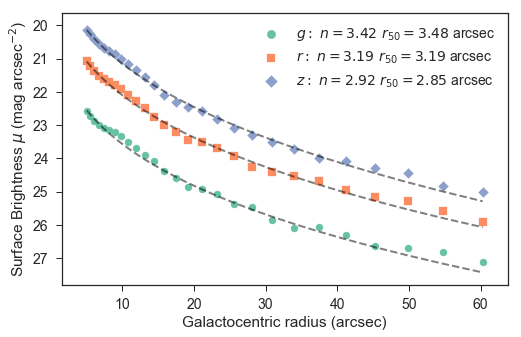

In [15]:
rr = sersicfit.fit(plot=True)

In [16]:
rr['phot']

flux_obs_g,flux_obs_r,flux_obs_z,flux_g,flux_r,flux_z,dm_in_g,dm_in_r,dm_in_z,dm_out_g,dm_out_r,dm_out_z,dm_g,dm_r,dm_z
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
678.732,2481.22,5605.71,1046.36,3733.24,8158.91,17.0531,15.6054,14.6787,16.6603,15.4196,14.7941,16.0865,14.756,13.9823
